__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 7, 5)      0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 20, 7, 5)     220         input_2[0][0]                    
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 20, 7, 5)     0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 20, 6, 5)     0           activation_3[0][0]               
__________________________________________________________________________________________________
conv2d_4 (

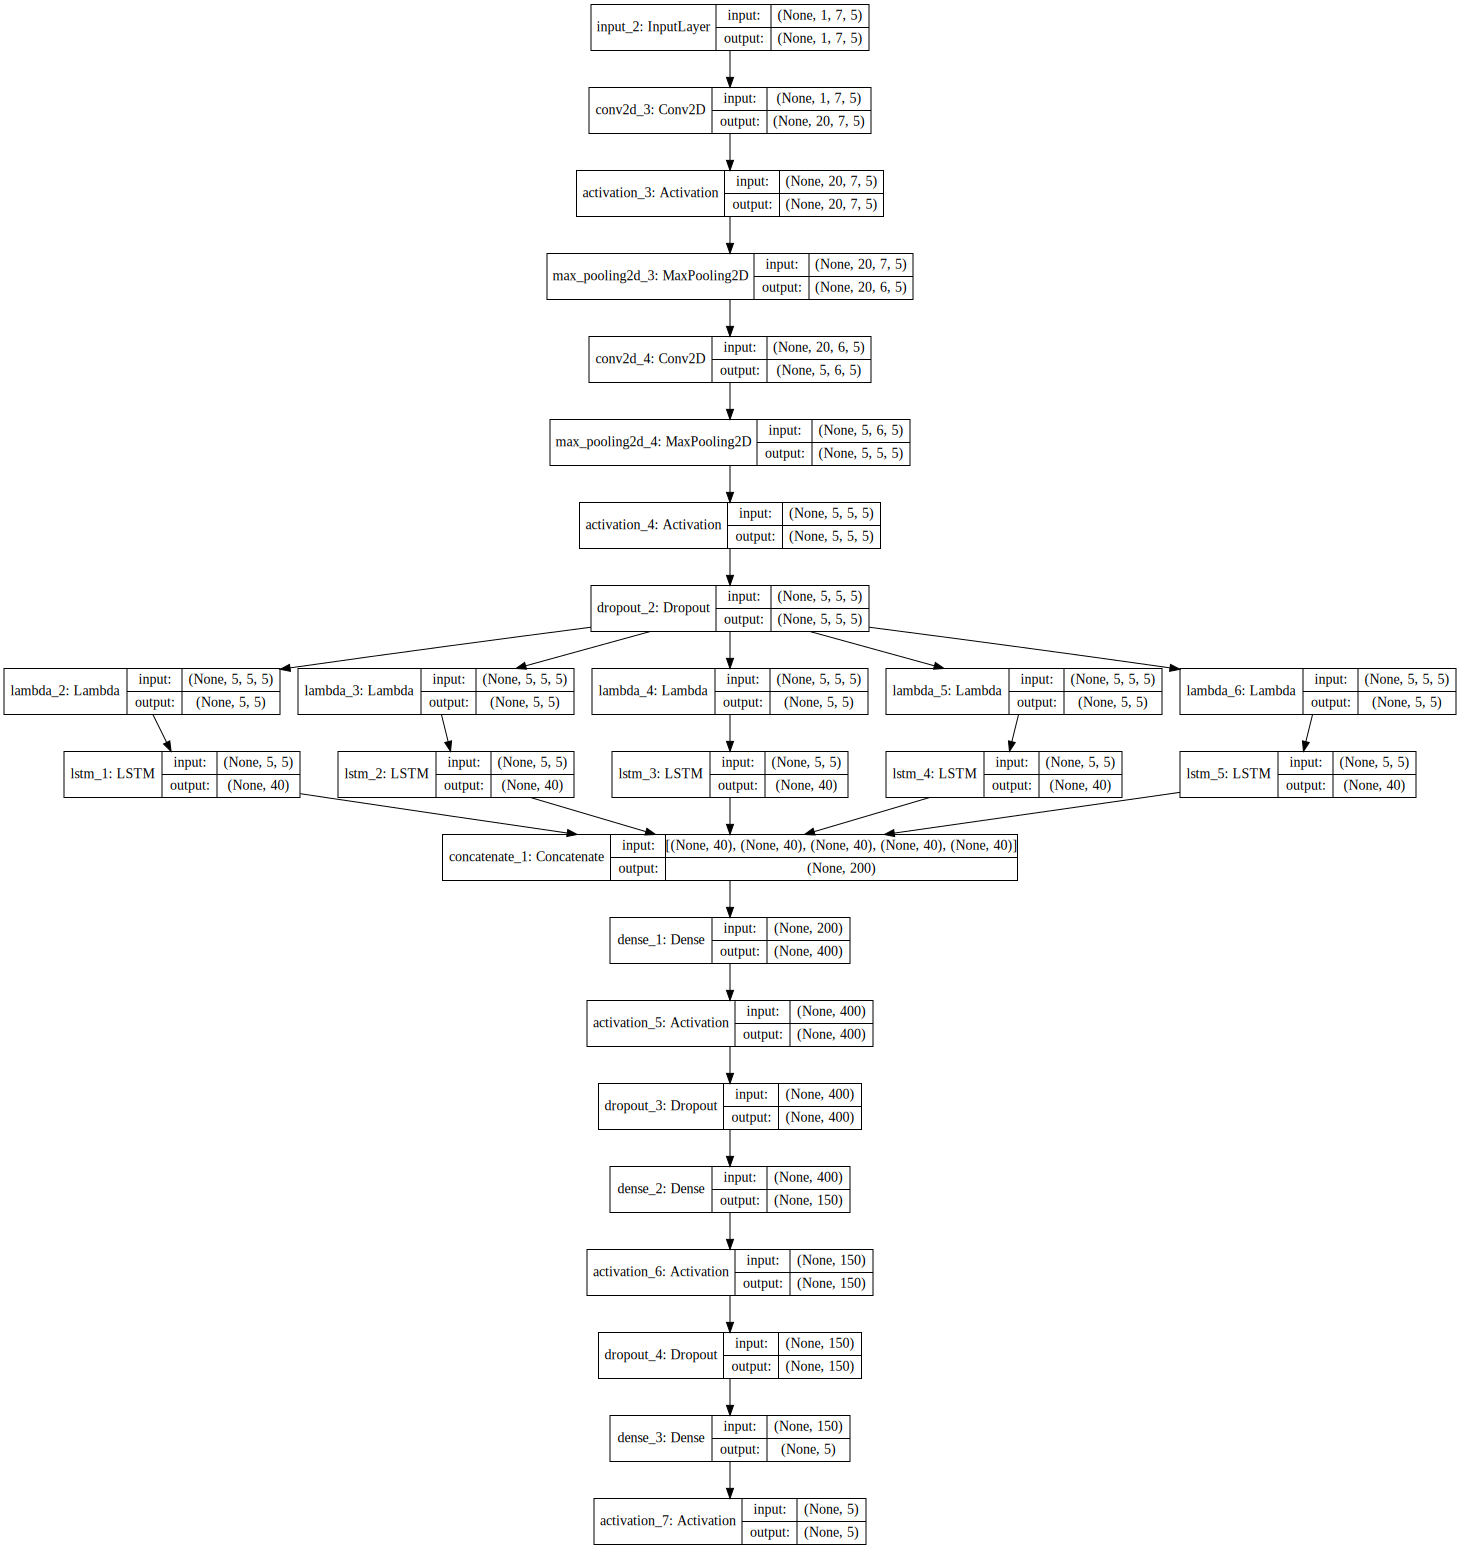

In [2]:
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from keras.layers.core import Activation, Lambda, Dropout 
from keras.layers.recurrent import LSTM
from keras.layers import merge,Concatenate
from keras.layers.merge import concatenate
from keras.models import Model
from keras.utils.vis_utils import plot_model

K.set_image_dim_ordering("th")


# element format
# [samples in batch , cnn filtered image N , timesteps , variables ]
def getSingleFilteredImage(element,number):
    return element[:,number,:,:]


def transform(element,n):
    batchResultFlat=[]
    for batchElement in element:
        resultFlat=[]
        for cnnFilterImage in batchElement:
            print(cnnFilterImage)
            firstColumns=cnnFilterImage[:,list(range(n))]
            print( np.array(firstColumns))
            result=np.concatenate((cnnFilterImage,np.array(firstColumns)),axis=1)
            print(result)
            print(np.flipud(list(range(cnnFilterImage.shape[1]-n,cnnFilterImage.shape[1]))))
            #lastColumnsReverse=cnnFilterImage[:,np.flipud(list(range(cnnFilterImage.shape[1]-n,cnnFilterImage.shape[1])))]
            lastColumnsReverse=cnnFilterImage[:,list(range(cnnFilterImage.shape[1]-n,cnnFilterImage.shape[1]))]
            print(lastColumnsReverse)
            result=np.concatenate((np.array(lastColumnsReverse),result),axis=1)
            print(result)
            resultFlat.append(result)
        batchResultFlat.append(np.array(resultFlat))
    print(np.array(batchResultFlat))
    newElement = np.array(batchResultFlat)
    return newElement

class RJPGNet:
    @staticmethod
    def build(timeSteps,variables,classes,nlstms):
        #CONV=>POOL
        inputNet = Input(shape=(1,timeSteps,variables)) 
        conv1=Conv2D(20, (2,5), padding="same")(inputNet)
        conv1=Activation("relu")(conv1)
        conv1=MaxPooling2D(pool_size=(2, 1), strides=(1, 1))(conv1)
        conv2=Conv2D(nlstms,(3,3), padding="same")(conv1)
        conv2=MaxPooling2D(pool_size=(2, 1), strides=(1, 1))(conv2)
        conv2=Activation("relu")(conv2)
        out1=Dropout(0.40)(conv2)
        lstmsVec=[]
        for x in range(0,nlstms):
            filterImg=Lambda(lambda element : getSingleFilteredImage(element,x))(out1)
            lstm=LSTM(40,input_shape=(5,5))(filterImg)
            lstmsVec.append(lstm)
        #base example for 2 lstms     
        #x0 = Lambda(lambda x : x[:,0,:,:])(out1)
        #x1 = Lambda(lambda x : x[:,1,:,:])(out1)
        #lstm1=LSTM(40,input_shape=(5,5))(x0)
        #lstm2=LSTM(40,input_shape=(5,5))(x1)
        
        merged = concatenate(lstmsVec)
        #merged = Concatenate(axis=-1)(lstmsVec)
        #merged = merge(lstmsVec, mode='concat',concat_axis=1)
        
        denselayers=Dense(400)(merged)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.5)(denselayers)
        denselayers=Dense(150)(denselayers)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.8)(denselayers)
        # a softmax classifier
        classificationLayer=Dense(classes)(denselayers)
        classificationLayer=Activation("softmax")(classificationLayer)
        
        model=Model(inputNet,classificationLayer)
        return model
        
        
#input
#timeSteps=7
#variables=5
#output
#classes=5
#concurret lstms
#nlstms=5

modeltest=RJPGNet.build(timeSteps=7,variables=5,classes=5,nlstms=5)
modeltest.compile(optimizer="adadelta", loss="categorical_crossentropy",metrics=["accuracy"])
modeltest.summary() 

#plot_model(modeltest, to_file="model.png",show_shapes=True)

#plot_model(modeltest, to_file="model.png",show_shapes=True)
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(modeltest,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)
